Parameters have to be changed for every stock and contract based on priors 

In [478]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [479]:
datafix = datafix.set_index("Date")

In [480]:
datafix["sma30"] = datafix["Close"].rolling(30).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 

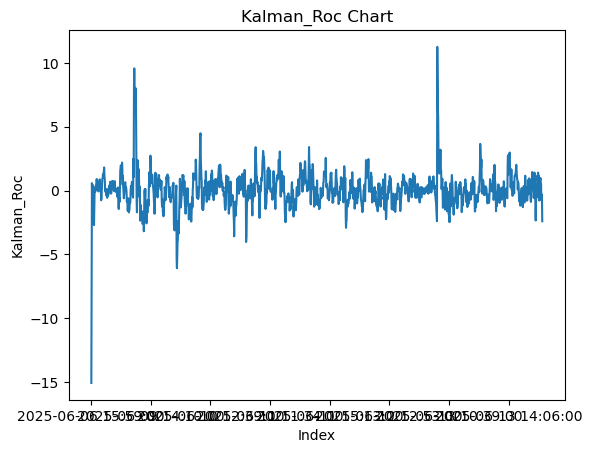

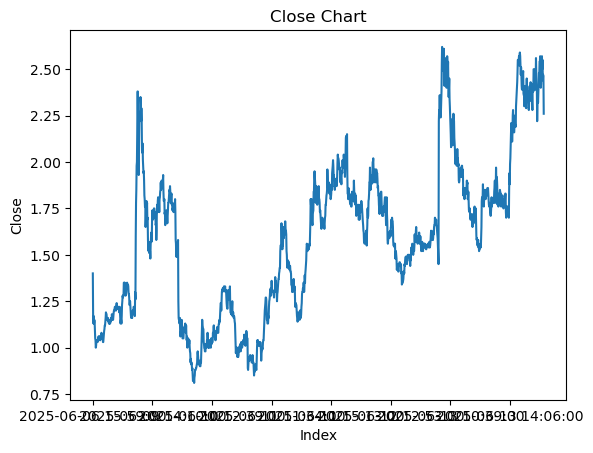

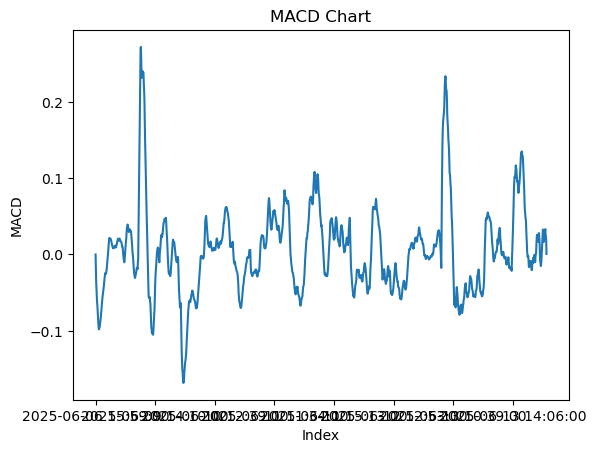

Column 'RSI' not found in datafix DataFrame.
Column 'sma' not found in datafix DataFrame.


In [481]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")
plot("Kalman_Roc")
plot("Close")
plot("MACD")
plot("RSI")
plot("sma")

In [482]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)


In [483]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,stock price,strike,rfr,type,IV,IVROC,sma30,smaspread,MACD_Hist_std,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-06 15:59:00,1.39,1.40,1.39,1.40,11.0,1.400000,NaN,0.000000,0.000000,0.000000,...,203.925,195,0.0429,p,0.297131,NaN,NaN,NaN,NaN,NaN
2025-06-09 10:02:00,1.17,1.17,1.17,1.17,3.0,1.189214,-15.056137,-0.018348,-0.003670,-0.014678,...,205.080,195,0.0429,p,0.332749,11.987342,NaN,NaN,NaN,NaN
2025-06-09 10:03:00,1.13,1.13,1.13,1.13,3.0,1.105323,-7.054292,-0.035704,-0.010076,-0.025628,...,204.980,195,0.0429,p,0.326502,-1.877187,NaN,NaN,NaN,NaN
2025-06-09 10:04:00,1.17,1.17,1.17,1.17,2.0,1.111729,0.579481,-0.045705,-0.017202,-0.028503,...,205.040,195,0.0429,p,0.331981,1.678008,NaN,NaN,NaN,NaN
2025-06-09 10:05:00,1.14,1.14,1.13,1.13,24.0,1.094789,-1.523672,-0.056210,-0.025004,-0.031207,...,205.150,195,0.0429,p,0.329744,-0.673828,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:55:00,2.54,2.55,2.40,2.55,44.0,2.528013,0.533253,0.033208,0.024887,0.008321,...,195.860,195,0.0429,p,0.281036,-0.076628,2.447667,-0.102333,0.618685,56.746430
2025-06-13 15:56:00,2.56,2.56,2.40,2.44,19.0,2.509183,-0.744855,0.026441,0.025198,0.001243,...,195.970,195,0.0429,p,0.275224,-2.068097,2.445667,0.005667,0.013268,48.780792
2025-06-13 15:57:00,2.45,2.49,2.44,2.47,248.0,2.501949,-0.288281,0.023231,0.024804,-0.001574,...,195.990,195,0.0429,p,0.278845,1.315822,2.444667,-0.025333,-0.306922,50.808859


In [484]:
import numpy as np

# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll3"] = datafix["Kalman_Roc"].rolling(3).mean()

buy_condition = (
    (datafix["MACD_Hist_std"] > 1) &
    (datafix["Kalman_Roc"] > 1.)
  #  & (datafix["Volume"].rolling(3).mean() < datafix["Volume"].rolling(12).mean())
)

datafix["Signal"] = None
datafix["max_gain"] = np.nan

in_position = False
current_max = np.nan
signals = [None] * len(datafix)

for int_idx, (df_idx, row) in enumerate(datafix.iterrows()):
    if not in_position:
        if buy_condition.loc[df_idx]:
            signals[int_idx] = "buy"
            in_position = True
            current_max = row["Close"]
            datafix.at[df_idx, "max_gain"] = current_max
    else:
        current_max = max(current_max, row["Close"])
        datafix.at[df_idx, "max_gain"] = current_max
        if (row["Close"] < current_max * 0.80) or (row["Kalman_Roc_roll3"] < -0.75):
            signals[int_idx] = "sell"
            in_position = False
            current_max = np.nan

datafix["Signal"] = signals
datafix["AvgVol"] = datafix["Volume"].rolling(20).mean()


In [485]:
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,type,IV,IVROC,sma30,smaspread,MACD_Hist_std,RSI,Kalman_Roc_roll3,max_gain,AvgVol
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-13 15:50:00,2.35,2.43,2.33,2.42,353.0,2.458546,-0.415388,0.016386,None,0.000023,...,p,0.279381,0.532626,2.425333,0.005333,-0.011553,49.481863,-0.628372,2.57,88.80
2025-06-13 15:51:00,2.44,2.51,2.39,2.50,44.0,2.471439,0.524384,0.019622,None,0.002608,...,p,0.282871,1.249160,2.432667,-0.067333,0.198453,54.925745,-0.222897,2.57,90.70
2025-06-13 15:52:00,2.46,2.53,2.44,2.53,47.0,2.489406,0.727007,0.024328,None,0.005851,...,p,0.281620,-0.441983,2.436333,-0.093667,0.451711,56.805519,0.278667,2.57,90.65
2025-06-13 15:53:00,2.53,2.57,2.53,2.57,119.0,2.513983,0.987260,0.030928,None,0.009961,...,p,0.281260,-0.127808,2.442000,-0.128000,0.790161,59.245975,0.746217,2.57,95.60
2025-06-13 15:54:00,2.56,2.56,2.50,2.50,29.0,2.514604,0.024694,0.030163,None,0.007356,...,p,0.281251,-0.003161,2.446000,-0.054000,0.573993,53.544582,0.579654,2.57,95.75
2025-06-13 15:55:00,2.54,2.55,2.40,2.55,44.0,2.528013,0.533253,0.033208,None,0.008321,...,p,0.281036,-0.076628,2.447667,-0.102333,0.618685,56.746430,0.515069,2.57,92.95
2025-06-13 15:56:00,2.56,2.56,2.40,2.44,19.0,2.509183,-0.744855,0.026441,None,0.001243,...,p,0.275224,-2.068097,2.445667,0.005667,0.013268,48.780792,-0.062303,2.57,93.60
2025-06-13 15:57:00,2.45,2.49,2.44,2.47,248.0,2.501949,-0.288281,0.023231,None,-0.001574,...,p,0.278845,1.315822,2.444667,-0.025333,-0.306922,50.808859,-0.166627,2.57,102.30
2025-06-13 15:58:00,2.44,2.46,2.42,2.46,177.0,2.493371,-0.342864,0.019653,None,-0.004121,...,p,0.277503,-0.481293,2.445333,-0.014667,-0.664891,50.096789,-0.458667,2.57,110.15


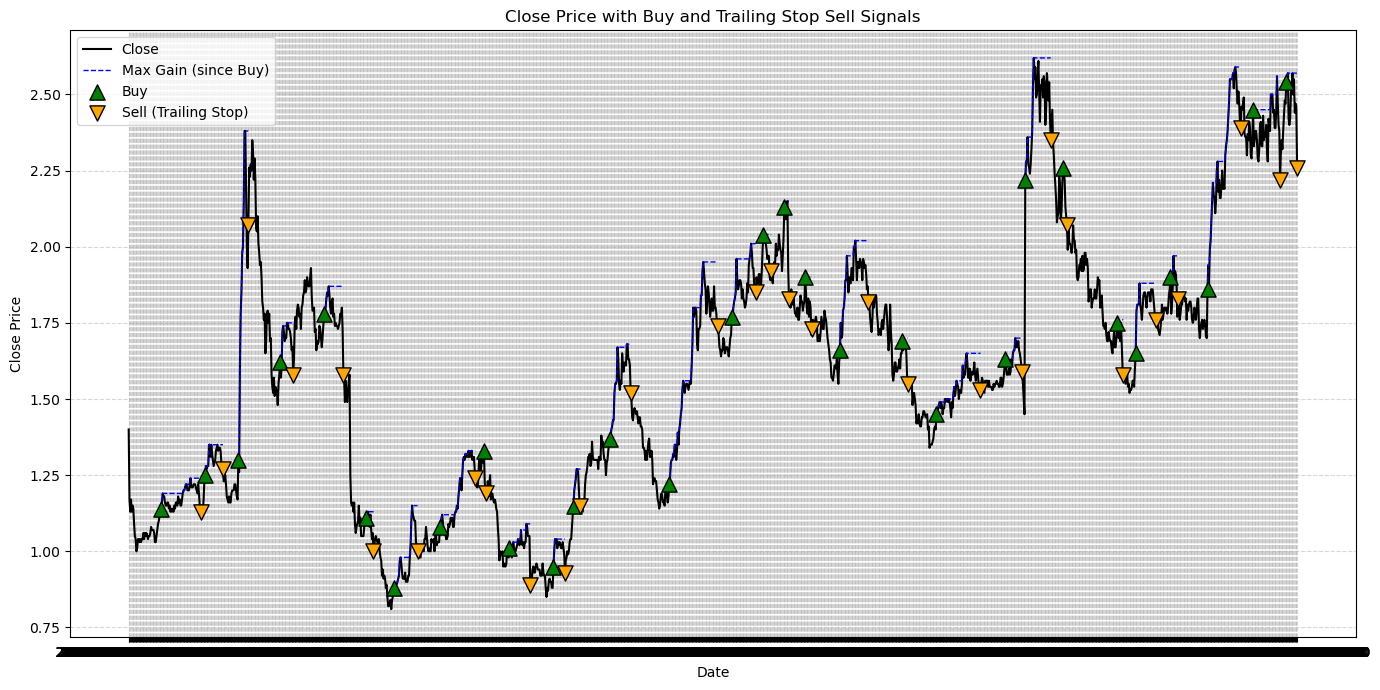

In [486]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# (Optional) Plot the running max_gain as a blue dashed line
plt.plot(datafix.index, datafix["max_gain"], label="Max Gain (since Buy)", color="blue", linestyle="dashed", linewidth=1)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Signal"] == "buy"]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Buy", zorder=3)

# Plot sell signals (orange downward triangle)
sell_signals = datafix[datafix["Signal"] == "sell"]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="orange", edgecolor="black", s=120, label="Sell (Trailing Stop)", zorder=3)

plt.title("Close Price with Buy and Trailing Stop Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



plt.show()


In [487]:
import pandas as pd

# Initialize lists to store trade details
buy_indices = []
sell_indices = []
buy_prices = []
sell_prices = []
buy_dates = []
sell_dates = []

in_position = False

for idx, row in datafix.iterrows():
    if not in_position and row["Signal"] == "buy":
        buy_indices.append(idx)
        buy_prices.append(row["Close"])
        buy_dates.append(row.name)
        in_position = True
    elif in_position and row["Signal"] == "sell":
        sell_indices.append(idx)
        sell_prices.append(row["Close"])
        sell_dates.append(row.name)
        in_position = False

# Ensure pairs are matched correctly
pairs = min(len(buy_prices), len(sell_prices))
buy_indices = buy_indices[:pairs]
sell_indices = sell_indices[:pairs]
buy_prices = buy_prices[:pairs]
sell_prices = sell_prices[:pairs]
buy_dates = buy_dates[:pairs]
sell_dates = sell_dates[:pairs]

# Calculate returns for each trade
returns = [(sell - buy) / buy for buy, sell in zip(buy_prices, sell_prices)]

# Create the 'test' DataFrame with trade details and returns
test = pd.DataFrame({
    "Buy_Index": buy_indices,
    "Sell_Index": sell_indices,
    "Buy_Date": buy_dates,
    "Sell_Date": sell_dates,
    "Buy_Price": buy_prices,
    "Sell_Price": sell_prices,
    "Return": returns
})


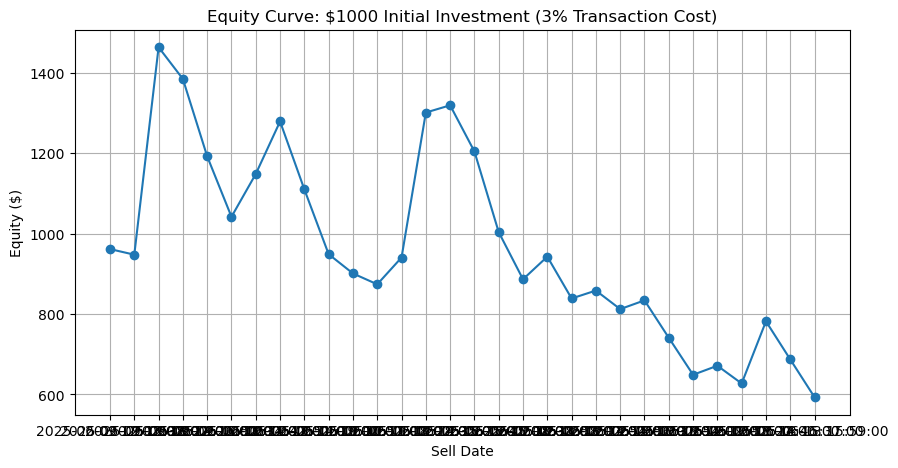

In [488]:
import matplotlib.pyplot as plt

initial_capital = 1000
equity_curve = [initial_capital]

for ret in test["Return"]:
    # Apply 3% transaction cost to each trade
    net_return = (1 + ret) * 0.97  # 3% cost
    equity_curve.append(equity_curve[-1] * net_return)

# Remove the initial capital for plotting (so curve aligns with trades)
equity_curve = equity_curve[1:]
test["Equity"] = equity_curve

plt.figure(figsize=(10,5))
plt.plot(test["Sell_Date"], test["Equity"], marker='o')
plt.title("Equity Curve: $1000 Initial Investment (3% Transaction Cost)")
plt.xlabel("Sell Date")
plt.ylabel("Equity ($)")
plt.grid(True)
plt.show()
